In [6]:
import os
import pandas as pd
import numpy as np
import re

import requests
import json

from plotnine import *

# Search cnn news and return articles

In [8]:
# we are going to begin searching cnn for X (e.g. coronavirus)
# we will get information on how many articles the search returns and the articles themselves
def update_cnn_article(search_term):

    # first read the meta dataframe that stores all data for articles already retrieved
    # if the meta file doens't exist, (i.e. we are searching for the first time), create an empty one
    # the following keys are the headings for the dataframe
    keys = ['_id','type','sourceId','url','firstPublishDate','lastPublishDate','lastModifiedDate','path','source','location','byLine','headline','body','section','mappedSection', 'thumbnail', 'livestorySourceId']    
    file = 'meta_' + search_term + '.csv'
    if not os.path.exists(path + file):
        meta = pd.DataFrame(columns = keys)
        meta.to_csv(path + file, index = False)
        # store all articles ids already collected, now it's empty
        existing_ids = meta['_id'].tolist()

    else:
        # read the meta data
        meta = pd.read_csv(path + file)
        # store all articles ids already collected
        existing_ids = meta['_id'].tolist()

    # here we initialize the search
    start = len(existing_ids)

    # total_count = total number of news articles returned for a search inquery
    # we don't how many yet, just setting it to be larger than start to initialize 
    total_count = start+1 


    # as long as the number of news articles already retrieved is less total available
    # we keep retrieving
    while start < total_count:

        # retrieve news articles
        # using the "retrieve_cnn_article" function defined below
        start, total_count, article_list = retrieve_cnn_article(search_term, start = start)

        # print progress
        print(str(start)+'/'+str(total_count))

        # read the meta data again to update currently collected articles
        meta = pd.read_csv(path+file)
        # store all articles ids already collected again
        existing_ids = meta['_id'].tolist()

        # create an empty list to store new articles 
        new_article = []

        # article_list['result'] contains actual list of articles retrieved
        # loop to save each article retrieved 
        for article in article_list['result']:

            # double check if the new article has not already been collected
            if article['_id'] not in existing_ids:

                # dump the new article to the new list  
                new_article.append(article)

                # save the full text of articles to a txt file, name by the '_id' cnn assigned,
                # in a folder called article_txt
                # if the folder doesn't exsit, create one
                if not os.path.exists(path+'article_txt/'):
                    os.makedirs(path+'article_txt/')

                # save full text as txt file
                with open(path+'article_txt/'+article['_id']+'.txt', "w",encoding="utf-8") as text_file:
                    text_file.write(article['body'])

        # if the new_article list is not empty, we need to update the meta dataframe
        if new_article:
            # convert the list into a dataframe
            df = pd.DataFrame(new_article)

            # fill in missing columns and order columns
            for key in keys:
                if key not in df.columns:
                    df[key] = ''
            df = df[keys]

            # de-dup df
            df = df.drop_duplicates('_id')

            # shorten text to first 100 words of the full text
            df['body'] = df['body'].apply(lambda x: ' '.join(x.split()[:100]))

            # append the new df to the existing meta
            # save to local csv file so it's updated for the next loop
            meta = pd.concat([meta, df])
            meta.to_csv(path + file, index = False)

In [9]:
# define a function to retrieve cnn news articles by searching a keyword
def retrieve_cnn_article(search_term, start, size = 100, size_step = 20):
    # this is the cnn api to retrieve news articles through search
    # from the latest articles to the oldest
    url = "https://search.api.cnn.io/content?q="+ search_term + "&size=" + str(size) + "&from=" + str(start) + '&sort=newest' + "&category=us,politics,world,opinion,health"

    # the api call returns all results of a search inquery (a list of json objects)
    article_list = requests.get(url = url) 
    article_list = article_list.json()

    # if error, decrease number of news to retrieve and run again
    if 'errorType' in article_list:
        # size_step = decrease by X
        # currently set to decrease 20 at a time
        # i.e, the second try will retrieve 80 articles
        size -= size_step 

    # if the call ran successfully, i.e. no error
    # return the results

    else:
        # return some meta data
        total_count = article_list['meta']['of']
        current_count = article_list['meta']['end']

        return current_count, total_count, article_list

# Start searching cnn...

In [10]:
# you could add more keywords related to each event if you wish
keywords_covid = ['coronavirus','covid-19']
keywords_blm = ['black lives matter','george floyd']

for keyword in keywords_covid:
    print(keyword)
    update_cnn_article(keyword)
    
for keyword in keywords_blm:
    print(keyword)
    update_cnn_article(keyword)

# Clean data

In [12]:
keywords_covid = ['coronavirus','covid-19']
keywords_blm = ['black lives matter','george floyd']

# read in all the articles searched using virus related keywords
meta_covid = pd.concat([pd.read_csv(path + 'meta_' + keyword + '.csv') for keyword in keywords_covid])

# read in all the articles searched using blm related keywords
meta_blm = pd.concat([pd.read_csv(path + 'meta_' + keyword + '.csv') for keyword in keywords_blm])

In [26]:
# remove duplicated _ids in each dataframe
meta_covid = meta_covid.drop_duplicates('_id')
meta_blm = meta_blm.drop_duplicates('_id')

# convert firstPublishDate to date format
meta_covid['firstPublishDate'] = pd.to_datetime(meta_covid['firstPublishDate'])
meta_blm['firstPublishDate'] = pd.to_datetime(meta_blm['firstPublishDate'])

# remove stories published before 2020
meta_covid = meta_covid[meta_covid['firstPublishDate'].dt.year>2019]
meta_blm = meta_blm[meta_blm['firstPublishDate'].dt.year>2019]

# add a column seperating covid vs blm, then combine the two datasets
meta_covid['event'] = 'COVID Articles'
meta_blm['event'] = 'BLM Articles'

meta = pd.concat([meta_covid, meta_blm])

# Plot

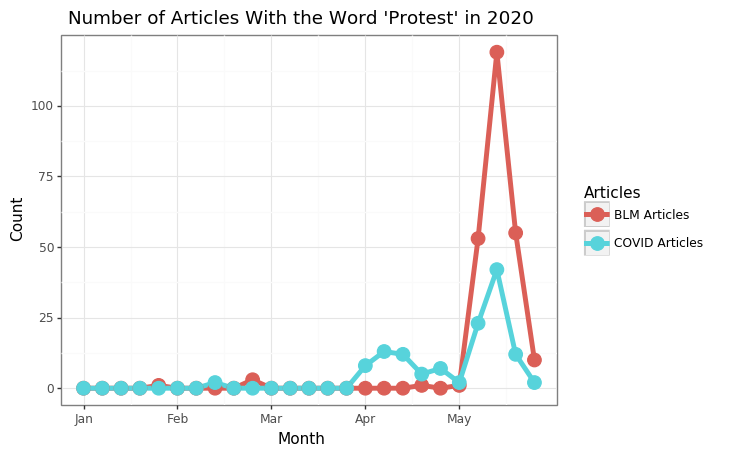

<ggplot: (8790868024437)>

In [27]:
# plot headlines containing the word protest

df = meta
# find headlines with the word protest
df['has_word'] = meta['headline'].str.lower().str.contains('protest')

# add the week in which the article is published
df['week'] = df['firstPublishDate'].dt.week

# aggregate by week and event (blm vs covid)
df = df.groupby(['event','week'])['has_word'].agg(n ='sum')

# fill in weeks that have no headlines with 'protest' with '0'
df = df.unstack(fill_value=0).stack().reset_index()

# plot 
ggplot(aes(x = 'week', y = 'n', color = 'event'), data = df)+\
    geom_line(size = 2) +\
    geom_point(size = 5) +\
    theme_bw() +\
    ggtitle("Number of Articles With the Word 'Protest' in 2020") +\
    scale_x_continuous(breaks = range(1,25,5), labels = ['Jan','Feb','Mar','Apr','May']) +\
    labs(color = 'Articles') +\
    xlab('Month') +\
    ylab('Count')
